# Assignment 1

## Id numbers and names


1.   313326985 Shahar Shcheranski
2.   206172686 Sarit Hollander

## 1. forward propagation process:

In [ ]:
import numpy as np
from time import time

In [ ]:
def initialize_parameters(layer_dims):
    """

    :param layer_dims: an array of the dimensions of each layer in the network
    (layer 0 is the size of the flattened input, layer L is the output softmax
    :return: a dictionary containing the initialized W and b parameters of each layer (W1…WL, b1…bL)
    """
    parameters = {}
    for i in range(1, len(layer_dims)):
        parameters['W' + str(i)] = np.random.randn(layer_dims[i], layer_dims[i - 1]) * np.sqrt(2/layer_dims[i-1])
        parameters['b' + str(i)] = np.zeros((layer_dims[i], 1))

    return parameters

In [ ]:
def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation
    :param A: the activations of the previous layer
    :param W: the weight matrix of the current layer (of shape [size of current layer, size of previous layer])
    :param b: the bias vector of the current layer (of shape [size of current layer, 1])
    :return: Z – the linear component of the activation function (i.e., the value before applying the non-linear function)
    linear_cache – a dictionary containing A, W, b (stored for making the backpropagation easier to compute)
    """
    Z = np.dot(W, A) + b
    linear_cache = {'A': A, 'W': W, 'b': b}
    
    return Z, linear_cache

In [ ]:
def softmax(Z):
    """
    :param Z: the linear component of the activation function
    :return: A – the activations of the layer
    activation_cache – returns Z, which will be useful for the backpropagation
    """
    z_exp = np.exp(Z)
    A = z_exp / np.sum(z_exp, axis=0)
    activation_cache = {'Z': Z}

    return A, activation_cache

In [ ]:
def relu(Z):
    """
    :param Z: the linear component of the activation function
    :return: A – the activations of the layer
    activation_cache – returns Z, which will be useful for the backpropagation
    """
    def relu_return_max(z):
        return np.maximum(0., z)

    activation_cache = {'Z': Z}
    relu_return_max = np.vectorize(relu_return_max)
    A = relu_return_max(Z)
    
    return A, activation_cache

In [ ]:
def relu_dropout(Z,prob):
    """
    :param Z: the linear component of the activation function
    :param prob: the probability of keeping a node in each layer
    :return: A – the activations of the layer
    activation_cache – returns Z, D, prob, which will be useful for the backpropagation
    """

    A, relue_cache = relu(Z)
    A, dropout_cache = dropout(A, prob)
    activation_cache = {**relue_cache, **dropout_cache}
    return A, activation_cache

In [ ]:
def dropout(A, prob):
    """
    :param A: the activations of the layer
    :param prob: the probability of keeping a node in each layer
    :return: A – the activations of the layer
    dropout_cache – returns Z, D, prob, which will be useful for the backpropagation
    """
    D = np.random.rand(A.shape[0],A.shape[1]) < prob
    A = A*D
    A = A/prob
    dropout_cache = {'D': D, 'prob' : prob}
    return A, dropout_cache

In [ ]:
def linear_activation_forward(A_prev, W, B, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer
    :param A_prev: activations of the previous layer
    :param W: the weights matrix of the current layer
    :param B: the bias vector of the current layer
    :param activation: the activation function to be used (a string, either “softmax” or “relu”)
    :return: A – the activations of the current layer
    cache – a joint dictionary containing both linear_cache and activation_cache
    """
    Z, linear_cache = linear_forward(A_prev, W, B)
    if activation == "softmax":
        A, activation_cache = softmax(Z)
    elif activation == "relu":
        if use_dropout:
          A, activation_cache = relu_dropout(Z, prob=prob_dropout)
        else:
          A, activation_cache = relu(Z)


    cache = {**linear_cache, **activation_cache}

    return A, cache

In [ ]:
def L_model_forward(X, parameters, use_batchnorm):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SOFTMAX
    :param X: the data, numpy array of shape (input size, number of examples)
    :param parameters: the initialized W and b parameters of each layer
    :param use_batchnorm: - a boolean flag used to determine whether to apply batchnorm after the activation
    (note that this option needs to be set to “false” in Section 3 and “true” in Section 4).
    :return: AL – the last post-activation value
    caches – a list of all the cache objects generated by the linear_forward function
    """
    layers = len(parameters) // 2
    A_prev = X
    caches = []

    for i in range(1, layers):
        W = parameters['W' + str(i)]
        b = parameters['b' + str(i)]
        A, cache = linear_activation_forward(A_prev, W, b, 'relu')
        caches.append(cache)
        if use_batchnorm:
            A = apply_batchnorm(A)

        A_prev = A

    W = parameters['W' + str(layers)]
    b = parameters['b' + str(layers)]
    AL, cache = linear_activation_forward(A_prev, W, b, 'softmax')
    caches.append(cache)

    return AL, caches

In [ ]:
def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation. The requested cost function is categorical cross-entropy loss.
    :param AL: probability vector corresponding to your label predictions, shape (num_of_classes, number of examples)
    :param Y: the labels vector (i.e. the ground truth)
    :return: cost – the cross-entropy cost
    """
    m = AL.shape[1]
    cost = -(1/m) * np.sum(Y * np.log(AL))
    return cost

In [ ]:
def apply_batchnorm(A):
    """
    performs batchnorm on the received activation values of a given layer.
    :param A: the activation values of a given layer
    :return: NA - the normalized activation values, based on the formula learned in class
    """
    mu = np.mean(A, axis=1, keepdims=True)
    eps = 0.00000001
    var = np.var(A, axis=1, keepdims=True)
    NA = (A - mu) / np.sqrt(var + eps)

    return NA

## 2. backward propagation process

In [ ]:
def Linear_backward(dZ, cache):
  """
  Description:
    Implements the linear part of the backward propagation process for a single layer

  Inputs:
    dZ - the gradient of the cost with respect to the linear output of the current layer (layer l)
    cache - tuple of values (A_prev, W, b) coming from the forward propagation in the current layer 

  Output: 
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
  """

  A_prev = cache['A']
  W = cache['W']
  b = cache['b']

  m = A_prev.shape[1]

  dA_prev = np.dot(W.T, dZ)
  dW = np.dot(dZ, A_prev.T)/m
  db = np.sum(dZ, axis=1, keepdims=True)/m

  return dA_prev, dW, db

In [ ]:
def linear_activation_backward(dA, cache, activation):
  """ 
  Description:
    Implements the backward propagation for the LINEAR->ACTIVATION layer. The function first computes dZ and then applies the linear_backward function.

  Input:
    dA – post activation gradient of the current layer
    cache – contains both the linear cache and the activations cache

  Output:
    dA_prev – Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW – Gradient of the cost with respect to W (current layer l), same shape as W
    db – Gradient of the cost with respect to b (current layer l), same shape as b
  """

  if activation == 'relu':
    if use_dropout:
      dZ = relu_dropout_backward(dA, cache)
    else:
      dZ = relu_backward(dA, cache)
  elif activation == 'softmax':
      dZ = softmax_backward(dA, cache)

  dA_prev, dW, db = Linear_backward(dZ, cache)

  return dA_prev, dW, db

In [ ]:
def relu_backward (dA, activation_cache):
  """
  Description:
    Implements backward propagation for a ReLU unit

  Input:
    dA – the post-activation gradient
    activation_cache – contains Z (stored during the forward propagation)

  Output:
    dZ – gradient of the cost with respect to Z
  """
  
  Z = activation_cache['Z']

  dZ = dA
  dZ[Z < 0] = 0

  return dZ


In [ ]:
def relu_dropout_backward(dA, activation_cache):
  """
  Description:
    Implements backward propagation for a dropout ReLU unit

  Input:
    dA – the post-activation gradient
    activation_cache – contains Z (stored during the forward propagation)

  Output:
    dZ – gradient of the cost with respect to Z
  """

  dA = dropout_backward(dA, activation_cache)
  dZ = relu_backward (dA, activation_cache)

  return dZ


In [ ]:
def softmax_backward (dA, activation_cache):
  """
  Description:
    Implements backward propagation for a softmax unit

  Input:
    dA – the post-activation gradient
    activation_cache – contains: 
      Z (stored during the forward propagation)
      AL - the probabilities vector, the output of the forward propagation (L_model_forward)
      Y - the true labels vector (the "ground truth" - true classifications)

  Output:
    dZ – gradient of the cost with respect to Z
  """

  Z = activation_cache['Z']
  AL = activation_cache['AL']
  Y = activation_cache['Y']

  dZ = AL - Y

  return dZ


In [ ]:
def dropout_backward(dA, dropout_cache):

  D = dropout_cache['D']
  prob = dropout_cache['prob']

  dA = dA*D
  dA = dA/prob

  return dA


In [ ]:
def L_model_backward(AL, Y, caches):
  """
  Description:
    Implement the backward propagation process for the entire network.

  Input:
    AL - the probabilities vector, the output of the forward propagation (L_model_forward)
    Y - the true labels vector (the "ground truth" - true classifications)
    Caches - list of caches containing for each layer: a) the linear cache; b) the activation cache

  Output:
    Grads - a dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ...
  """
    
  layers = len(caches)
  grads = {}

  # Initializing the backpropagation
  dAL = - (Y/AL) + (1 - Y)/(1 - AL)

  # Lth layer (ACTIVATION -> LINEAR) gradients. 
  current_cache = caches[layers - 1]
  current_cache['AL'] = AL
  current_cache['Y'] = Y
  grads['dA' + str(layers)], grads['dW' + str(layers)], grads['db' + str(layers)] = linear_activation_backward(dAL, current_cache, activation = 'softmax')

  for i in range(layers - 1, 0, -1):
      previous_layer = i + 1
      curreny_layer = i
      current_cache = caches[i - 1]
      grads['dA' + str(curreny_layer)], grads['dW' + str(curreny_layer)], grads['db' + str(curreny_layer)] = linear_activation_backward(grads['dA' + str(previous_layer)], current_cache, activation = 'relu')

  return grads



In [ ]:
def Update_parameters(parameters, grads, learning_rate):
  """
  Description:
    Updates parameters using gradient descent

  Input:
    parameters – a python dictionary containing the DNN architecture’s parameters
    grads – a python dictionary containing the gradients (generated by L_model_backward)
    learning_rate – the learning rate used to update the parameters (the “alpha”)

  Output:
    parameters – the updated values of the parameters object provided as input
  """

  layers = len(parameters) // 2

  for i in range(1, layers + 1):
    parameters['W' + str(i)] = parameters['W' + str(i)] - (learning_rate * grads['dW' + str(i)])
    parameters['b' + str(i)] = parameters['b' + str(i)] - (learning_rate * grads['db' + str(i)])
                                                           
  return parameters

## 3. train the network and produce predictions

In [ ]:
import math

In [ ]:
# global parameters
use_batchnorm = False
stopping_rate = 0.001
splitting_factor = 0.2
use_dropout = False
prob_dropout = 0.8

In [ ]:
def L_layer_model(X, Y, layers_dims, learning_rate, num_iterations, batch_size):
  """
  Description:
    Implements a L-layer neural network. All layers but the last should have the ReLU activation function, and the final layer will apply the softmax activation function. The size of the output layer should be equal to the number of labels in the data. Please select a batch size that enables your code to run well (i.e. no memory overflows while still running relatively fast).

    Hint: the function should use the earlier functions in the following order: initialize -> L_model_forward -> compute_cost -> L_model_backward -> update parameters

  Input:
    X – the input data, a numpy array of shape (height*width , number_of_examples) 
    Comment: since the input is in grayscale we only have height and width, otherwise it would have been height*width*3
    Y – the “real” labels of the data, a vector of shape (num_of_classes, number of examples)
    Layer_dims – a list containing the dimensions of each layer, including the input
    batch_size – the number of examples in a single training batch.

  Output:
    parameters – the parameters learnt by the system during the training (the same parameters that were updated in the update_parameters function).
    costs – the values of the cost function (calculated by the compute_cost function). One value is to be saved after each 100 training iterations (e.g. 3000 iterations -> 30 values)
  """
  num_of_classes = Y.shape[0]
  data = np.concatenate([X, Y], axis=0)
  np.random.shuffle(data.T)
  samples = int(splitting_factor * data.shape[1])
  train = data[:, samples:]
  x_train, y_train = train[:-num_of_classes, :], train[-num_of_classes:, :]
  test = data[:, :samples]
  x_test, y_test = test[:-num_of_classes, :], test[-num_of_classes:, :]

  data = np.concatenate([x_train, y_train], axis=0)
  number_of_examples = x_train.shape[1]

  num_of_batches = math.ceil(number_of_examples / batch_size)

  parameters = initialize_parameters(layers_dims)
  costs = []

  iter = 0
  while len(costs) < 2 or np.abs(costs[-2] - costs[-1]) > stopping_rate:
      if iter % num_of_batches == 0:
          np.random.shuffle(data.T)
          all_batches = np.array_split(data, indices_or_sections=num_of_batches, axis=1)
      batch_divided = iter % num_of_batches
      curr_x_batch = all_batches[batch_divided][0:x_train.shape[0], :]
      curr_y_batch = all_batches[batch_divided][x_train.shape[0]:, :]

      AL, caches = L_model_forward(curr_x_batch, parameters,use_batchnorm=use_batchnorm)
      grads = L_model_backward(AL, curr_y_batch, caches)
      parameters = Update_parameters(parameters, grads, learning_rate)

      iter += 1

      if iter % num_iterations == 0:
          AL = L_model_forward(x_test, parameters,use_batchnorm=use_batchnorm)[0]
          cost = compute_cost(AL, y_test)
          costs.append(cost)
          print('Iteration number: ' + str(iter) + ', cost: ' + str(cost))

  if iter % num_of_batches == 0:
        print('iterated on ' + str(iter // num_of_batches) + ' epochs')
  else:
        print('iterated on ' + str(iter // num_of_batches) + ' epochs and ' + str(iter % num_of_batches) + ' iterations')

  train_accuracy = Predict(X=x_train, Y=y_train, parameters=parameters) * 100
  test_accuracy = Predict(X=x_test, Y=y_test, parameters=parameters) * 100

  print('Train accuracy: ' + str(train_accuracy) + '%')
  print('Validation accuracy: ' + str(test_accuracy) + '%')

  return parameters, costs

In [ ]:
def Predict(X, Y, parameters):
  """
  Description:
    The function receives an input data and the true labels and calculates the accuracy of the trained neural network on the data.

  Input:
    X – the input data, a numpy array of shape (height*width, number_of_examples)
    Y – the “real” labels of the data, a vector of shape (num_of_classes, number of examples)
    Parameters – a python dictionary containing the DNN architecture’s parameters

  Output:
    accuracy – the accuracy measure of the neural net on the provided data (i.e. the percentage of the samples for which the correct label receives the hughest confidence score). Use the softmax function to normalize the output values.
  """
  number_of_examples = X.shape[1]

  AL, caches = L_model_forward(X, parameters, use_batchnorm)

  y_pred = np.argmax(AL, axis=0)
  y_true = np.argmax(Y, axis=0)

  correct = np.sum(y_pred == y_true)

  return correct/number_of_examples


## 4. classify the MNIST dataset

### a.	Load the dataset using the Keras code

Note that there is a predefined division between the train and test set. Use 20% of the training set as a validation set (samples need to be randomly chosen).

In [ ]:
from tensorflow import keras

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
# The input at each iteration needs to be “flattened” to a matrix of [m,784] where m is the number of samples

x_train = x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2])
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1]*x_test.shape[2]) 

In [ ]:
# Transform the labeles into one-hot encoded matrix

one_hot_train = np.zeros((y_train.size, 10))
one_hot_train[np.arange(y_train.size), y_train] = 1

y_train = one_hot_train

one_hot_test = np.zeros((y_test.size, 10))
one_hot_test[np.arange(y_test.size), y_test] = 1

y_test = one_hot_test

In [ ]:
# Normalize

x_train = x_train/255
x_test = x_test/255

### b.	Run your network

using the following configuration:
*   4 layers (aside from the input layer), with the following sizes: 20,7,5,10
*   Do not activate the batchnorm option at this point
*   The input at each iteration needs to be “flattened” to a matrix of [m,784]  where m is the number of samples
*   Use a learning rate of 0.009
*   Train the network until there is no improvement on the validation set (or the improvement is very small) for 100 training steps (this is the stopping criterion). Please include in the report the number of iterations and epochs needed to train your network. Also, specify the batch size.

In [ ]:
np.random.seed(10)

start_time = time()
params, costs = L_layer_model(X=x_train.T, Y=y_train.T, layers_dims=[784,20,7,5,10],learning_rate=0.009, num_iterations=100, batch_size=256)
end_time = time()

Iteration number: 100, cost: 2.140946214501379
Iteration number: 200, cost: 1.9282392544680587
Iteration number: 300, cost: 1.8262511902216816
Iteration number: 400, cost: 1.7443139537360717
Iteration number: 500, cost: 1.6697881141018145
Iteration number: 600, cost: 1.6033084415963446
Iteration number: 700, cost: 1.541559816856163
Iteration number: 800, cost: 1.4824780348323399
Iteration number: 900, cost: 1.4259559134060302
Iteration number: 1000, cost: 1.362867431396588
Iteration number: 1100, cost: 1.3004780078546945
Iteration number: 1200, cost: 1.2395499622190367
Iteration number: 1300, cost: 1.1817233768434643
Iteration number: 1400, cost: 1.1337055897849624
Iteration number: 1500, cost: 1.0875369181915069
Iteration number: 1600, cost: 1.047555406162395
Iteration number: 1700, cost: 1.0111468431220292
Iteration number: 1800, cost: 0.9785508219333166
Iteration number: 1900, cost: 0.9458758377839221
Iteration number: 2000, cost: 0.915823171619826
Iteration number: 2100, cost: 0.88

In [ ]:
print('Test accuracy: '+ str(Predict(X=x_test.T, Y=y_test.T, parameters=params) * 100) + '%')
print('Running Time: ' + str(end_time - start_time))

Test accuracy: 90.49000000000001%
Running Time: 228.07242965698242


Text(0, 0.5, 'Cost')

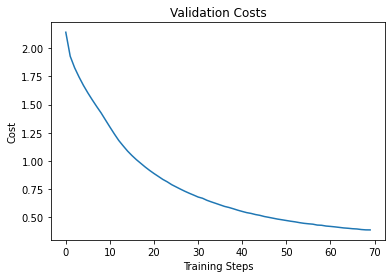

In [ ]:
import matplotlib.pyplot as plt

# Plot costs
plt.plot(costs)
plt.title('Validation Costs')
plt.xlabel('Training Steps')
plt.ylabel('Cost')

## 5. Repeat section 4 when the batchnorm function is “on”

Analyze and compare this experiment to the previous one (performance, running time, number of training steps etc.). There is no need to update the parameters of the batchnorm in the way described in the lecture.

In [ ]:
use_batchnorm = True

In [ ]:
np.random.seed(10)

start_time = time()
params, costs = L_layer_model(X=x_train.T, Y=y_train.T, layers_dims=[784,20,7,5,10],learning_rate=0.009, num_iterations=100, batch_size=256)
end_time = time()

Iteration number: 100, cost: 2.2012278531596743
Iteration number: 200, cost: 1.9723635312106331
Iteration number: 300, cost: 1.8562567317757954
Iteration number: 400, cost: 1.7840242202723242
Iteration number: 500, cost: 1.7265812033319434
Iteration number: 600, cost: 1.6805266338522304
Iteration number: 700, cost: 1.6355338111530555
Iteration number: 800, cost: 1.597995272916762
Iteration number: 900, cost: 1.562978667214431
Iteration number: 1000, cost: 1.5185826871161359
Iteration number: 1100, cost: 1.478213410015933
Iteration number: 1200, cost: 1.4383942774564014
Iteration number: 1300, cost: 1.4005104012056933
Iteration number: 1400, cost: 1.3646312815725588
Iteration number: 1500, cost: 1.3270451529345477
Iteration number: 1600, cost: 1.2957736602322956
Iteration number: 1700, cost: 1.2652590521421385
Iteration number: 1800, cost: 1.2335901961084477
Iteration number: 1900, cost: 1.204258592515176
Iteration number: 2000, cost: 1.1807007113964378
Iteration number: 2100, cost: 1.1

In [ ]:
print('Test accuracy: '+ str(Predict(X=x_test.T, Y=y_test.T, parameters=params) * 100) + '%')
print('Running Time: ' + str(end_time - start_time))

Test accuracy: 89.13%
Running Time: 326.4042909145355


Text(0, 0.5, 'Cost')

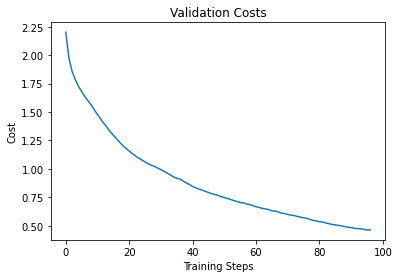

In [ ]:
# Plot costs
plt.plot(costs)
plt.title('Validation Costs')
plt.xlabel('Training Steps')
plt.ylabel('Cost')

## 6. Bonus

In [ ]:
use_batchnorm = False
use_dropout = True

In [ ]:
np.random.seed(10)

start_time = time()
params, costs = L_layer_model(X=x_train.T, Y=y_train.T, layers_dims=[784,20,7,5,10],learning_rate=0.009, num_iterations=100, batch_size=256)
end_time = time()

Iteration number: 100, cost: 2.246695790756403
Iteration number: 200, cost: 2.1435621090139314
Iteration number: 300, cost: 2.081946471816097
Iteration number: 400, cost: 2.038807944302734
Iteration number: 500, cost: 2.0014975743742096
Iteration number: 600, cost: 1.973300636006961
Iteration number: 700, cost: 1.9595073146223945
Iteration number: 800, cost: 1.9261571135035236
Iteration number: 900, cost: 1.9105179394538454
Iteration number: 1000, cost: 1.8958746284904997
Iteration number: 1100, cost: 1.8751713563876031
Iteration number: 1200, cost: 1.8494006635671685
Iteration number: 1300, cost: 1.8456589255726739
Iteration number: 1400, cost: 1.8338710894658998
Iteration number: 1500, cost: 1.8075060605401043
Iteration number: 1600, cost: 1.8029754517043186
Iteration number: 1700, cost: 1.7934663895122078
Iteration number: 1800, cost: 1.7804894354446301
Iteration number: 1900, cost: 1.7628209553653589
Iteration number: 2000, cost: 1.7554717542428135
Iteration number: 2100, cost: 1.7

In [ ]:
print('Test accuracy: '+ str(Predict(X=x_test.T, Y=y_test.T, parameters=params) * 100) + '%')
print('Running Time: ' + str(end_time - start_time))

Test accuracy: 40.68%
Running Time: 95.6027467250824


Text(0, 0.5, 'Cost')

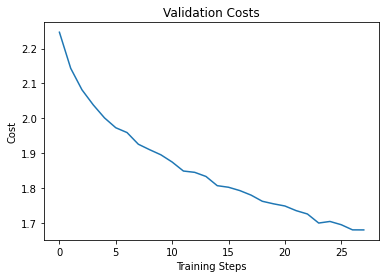

In [ ]:
# Plot costs
plt.plot(costs)
plt.title('Validation Costs')
plt.xlabel('Training Steps')
plt.ylabel('Cost')